<b><font size=6>Содержание</font></b><a name="1common."></a>
* [0. Описание проекта](#0.)
* [1. Описание данных](#1.)
    * [1.1. Общая информация о пользователях](#1.1.)
    * [1.2. Общая информация о звонках](#1.2.)
    * [1.3. Общая информация о сообщениях](#1.3.)
    * [1.4. Общая информация об интернет-сессиях](#1.4.)
    * [1.5. Общая информация о тарифах](#1.5.)
* [2. Добавление новых данных](#2.)
    * [2.1. Кол-во звонков и общая продолжительность звонка в разбивке по месяцам](#2.1.)
    * [2.2. Кол-во отправленных сообщений по месяцам](#2.2.)
    * [2.3. Объем израсходованного интернет-трафика по месяцам](#2.3.)
    * [2.4. Помесячная выручка с каждого пользователя](#2.4.)
* [3. Анализ данных](#3.)
* [4. Проверка гипотез](#4.)
    * [4.1. Гипотеза о различии средней выручки для разных тарифов](#4.1.)
    * [4.2. Гипотеза о различии средней выручки для пользователей из Москвы и из других регионов](#4.2.)
* [5. Общий вывод](#5.)

<b><font size=5>Определение перспективного тарифа для телеком компании</font></b><a name="0."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Оператор сотовой связи предлагает клиентам два тарифных плана: «Смарт» и «Ультра».  В нашем распоряжении данные 500 пользователей компании за 2018 год. 

*Цель:* проанализировать поведение клиентов и сделать вывод — какой тариф лучше, чтобы скорректировать рекламный бюджет.

<b><font size=5>1. Описание данных</font></b><a name="1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
# импорт всех необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from termcolor import colored

import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузим все данные

users = pd.read_csv('/datasets/users.csv') # информация о пользователях
calls = pd.read_csv('/datasets/calls.csv') # информация о звонках
messages = pd.read_csv('/datasets/messages.csv') # информация о сообщениях
internet = pd.read_csv('/datasets/internet.csv') # информация об интернет-сессиях
tariffs = pd.read_csv('/datasets/tariffs.csv') # информация о тарифах

<b><font size=3>Описание данных:</font></b>

<b><font size=2>Таблица users</font></b> (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

<b><font size=2>Таблица calls</font></b> (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

<b><font size=2>Таблица messages</font></b> (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

<b><font size=2>Таблица internet</font></b> (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

<b><font size=2>Таблица tariffs</font></b> (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [3]:
def general_info(data):
    ''' 
    Функция принимает на вход датафрейм и возвращает общую информацию о данных.
    '''
    print('Случайные 5 строк датафрейма')
    print('----------------------------')
    display(data.sample(5, random_state=42)) # выводим на экран рандомные 5 строк датафрейма
    print('Общая информация')
    print('----------------')
    display(data.info())
    print('Пропуски')
    print('--------')
    display(pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')) # выводим процент пропусков 
                                                                                                 # по каждому столбцу
    print('Дубликаты')
    print('---------')
    display(data.duplicated().sum())
    print('Описательная статистика')
    print('-----------------------')
    display(round(data.describe().T, 2))

Посмотрим более подробно общую информацию по каждой таблице.

<b><font size=4>1.1. Общая информация о пользователях</font></b><a name="1.1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [4]:
general_info(users)

Случайные 5 строк датафрейма
----------------------------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
361,1361,38,NaN,Екатеринбург,Рената,Кошелева,2018-09-09,ultra
73,1073,63,NaN,Владикавказ,Гордей,Павловский,2018-10-04,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
104,1104,60,NaN,Нижний Тагил,Габриэль,Поляков,2018-02-21,ultra


Общая информация
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.3+ KB


None

Пропуски
--------


,0
user_id,0
age,0
churn_date,92.4
city,0
first_name,0
last_name,0
reg_date,0
tariff,0


Дубликаты
---------


0

Описательная статистика
-----------------------


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.50,144.48,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.59,16.67,18.0,32.00,46.0,62.00,75.0


> Дубликатов нет. В таблице users в столбце churn_date (дата закрытия договора) 92% пропусков, что означает, что эти люди на момент выгрузки еще пользуются услугами данного оператора. Пока оставим этот столбец бех изменений. В описательной статистике показано, что минимальный возраст пользователей 18 лет, максимальный - 75, при этом средний возраст 47 лет.<br/>
Изменим типы данных, для уменьшения потребляемой памяти. Изменим тип object в столбце reg_date на тип datetime, а в столбце city на тип category.

In [5]:
def astype_columns(data):
    '''
    Функция меняет тип только столбцов с типами int и float на более подходящий (но занимающий меньший объем памяти).
    '''
    columns_int = data.select_dtypes(include=['int']).columns # выбираем из датасета все столбцы с типом int
    data.loc[:, columns_int] = data.loc[:, columns_int].apply(pd.to_numeric, downcast='integer') # меняем тип
    
    columns_float = data.select_dtypes(include=['float']).columns # аналогично, выбираем с типом float
    data.loc[:, columns_float] = data.loc[:, columns_float].apply(pd.to_numeric, downcast='float') # меняем тип
    

In [6]:
# изменим типы данных

astype_columns(users)
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['city'] = users['city'].astype('category')
users['tariff'] = users['tariff'].astype('category')

In [7]:
# проверка

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null category
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null category
dtypes: category(2), datetime64[ns](1), int64(2), object(3)
memory usage: 27.7+ KB


>Объем потребляемой амяти уменьшился с 31.3 КВ до 27.7 КВ.

In [8]:
# посмотрим на кол-во городов, из которых наши пользователи

print('список всех городов и количество пользователей в них')
print('----------------------------------------------------')
users['city'].value_counts()

список всех городов и количество пользователей в них
----------------------------------------------------


Москва              99
Санкт-Петербург     39
Новосибирск         16
Омск                14
Казань              14
Уфа                 12
Екатеринбург        11
Ульяновск           11
Набережные Челны    11
Краснодар           11
Челябинск            9
Самара               9
Нижний Новгород      8
Пермь                8
Волгоград            8
Улан-Удэ             7
Красноярск           7
Вологда              7
Новокузнецк          7
Киров                6
Пенза                6
Ростов-на-Дону       6
Иркутск              6
Тюмень               6
Воронеж              6
Сочи                 6
Томск                6
Магнитогорск         5
Балашиха             5
Ставрополь           5
                    ..
Брянск               3
Ярославль            3
Стерлитамак          3
Череповец            3
Нижний Тагил         3
Якутск               3
Чебоксары            3
Орёл                 3
Тверь                3
Саратов              3
Севастополь          3
Курск                2
Белгород   

> Всего 76 различных городов. Теперь посмотрим разбивку пользователей на два тарифа "смарт" и "ультра".

In [9]:
print('Разбивка пользователей по тарифам')
print('---------------------------------')
users['tariff'].value_counts(normalize=True)*100

Разбивка пользователей по тарифам
---------------------------------


smart    70.2
ultra    29.8
Name: tariff, dtype: float64

>Видим, что пользователей c тарифом "Смарт" 70%, а с тарифом "ультра" 30%.

In [10]:
print('Минимальная дата заключения договора:', users['reg_date'].min())
print('Максимальная дата заключения договора:', users['reg_date'].max())

Минимальная дата заключения договора: 2018-01-01 00:00:00
Максимальная дата заключения договора: 2018-12-31 00:00:00


>У нас выборка клиентов, которые заключили договор в 2018г. Нужно проанализировать их активность также за 2018г. Стоит в дальнейшем учесть клиентов, которые подключились в конце 2018г, т.к. у них активность пользования тарифами может быть ниже, чем у тех кто подключился в начале года.

<b><font size=3>Промежуточный вывод</font></b><br/>

Поменяли типы данных с столбцах с типами int и float на типы, которые потребляют меньше памяти. В столбце reg_date сменили тип с object на  datetime, в столбце city сменили тип с object на category.

Дубликатов не обнаружено.

Из 500 пользователей в выборке 70% - это пользователи тарифом "смарт", 30% - тарифом "ультра". Все пользователи подключились в 2018г. Из них на момент выгрузки данных 92% являются абонентами компании, 8% - отключили услуги компании.

<b><font size=4>1.2. Общая информация о звонках</font></b><a name="1.2."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [11]:
general_info(calls)

Случайные 5 строк датафрейма
----------------------------


,id,call_date,duration,user_id
158741,1392_406,2018-07-09,4.94,1392
95947,1244_202,2018-11-09,0.00,1244
10624,1027_494,2018-10-07,3.10,1027
167423,1412_340,2018-09-25,5.91,1412
73194,1184_168,2018-09-03,9.86,1184


Общая информация
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

Пропуски
--------


,0
id,0
call_date,0
duration,0
user_id,0


Дубликаты
---------


0

Описательная статистика
-----------------------


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.76,5.84,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.94,144.72,1000.0,1126.0,1260.0,1379.0,1499.0


>Пропусков и дубликатов нет. В описательной статистике видим высокое стандартное отклонение, что говорит о наличии выбросов. При этом 75% данных имеют длительность не выше 10,7 мин. Есть звонки длительностью 0 минут. Посмотрим поближе на звонки длительностью 0 минут дальше.<br/>
Проделаем тоже самое для таблицы calls: изменим типы данных, поищем дубликаты, проанализируем столбец duration (длительность звонка).



In [12]:
# изменяем типы данных

astype_columns(calls)
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [13]:
# проверка

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float32
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float32(1), int64(1), object(1)
memory usage: 5.4+ MB


>Объем памяти уменьшился на 13%. 

In [14]:
print('Звонки с нулевой длительностью')
print('------------------------------')
calls.loc[calls['duration'] == 0]

Звонки с нулевой длительностью
------------------------------


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
36,1000_36,2018-10-09,0.0,1000
38,1000_38,2018-05-25,0.0,1000
39,1000_39,2018-06-13,0.0,1000
40,1000_40,2018-10-25,0.0,1000
47,1000_47,2018-07-14,0.0,1000


>Звонки с длительностью 0 минут составляют 19.5% от всего датасета. Очень похоже, что это пропущенные звонки. Оставим их в таблице без изменений.<br/>
Посмотрим на минимальную и максималью даты звонка.

In [15]:
print('Минимальная дата звонка:', calls['call_date'].min())
print('Максимальная дата звонка:', calls['call_date'].max())

Минимальная дата звонка: 2018-01-01 00:00:00
Максимальная дата звонка: 2018-12-31 00:00:00


>С датами звонка все в порядке, они также в 2018г.

<b><font size=3>Промежуточный вывод</font></b><br/>

Поменяли типы данных с столбцах с типами int и float на типы, которые потребляют меньше памяти. В столбце call_date сменили тип с object на  datetime.

Дубликатов и пропущенных значений не обнаружено.

Нашли звонки с длительностью 0 минут. Они составляют 19.5% от всего датасета. Очень похоже, что это пропущенные звонки. Оставили их в таблице без изменений. Все звонки в датасете были сделаны в 2018г.

<b><font size=4>1.3. Общая информация о сообщениях</font></b><a name="1.3."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [16]:
general_info(messages)

Случайные 5 строк датафрейма
----------------------------


,id,message_date,user_id
8581,1033_332,2018-11-08,1033
12476,1054_32,2018-08-10,1054
14805,1065_141,2018-05-29,1065
118278,1481_49,2018-05-24,1481
23803,1099_10,2018-08-24,1099


Общая информация
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

Пропуски
--------


,0
id,0
message_date,0
user_id,0


Дубликаты
---------


0

Описательная статистика
-----------------------


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.99,143.52,1000.0,1134.0,1271.0,1381.0,1499.0


>Пропущенных значений и дубликатов нет. Изменим типы данных, проверим данные на дубликаты, проанализируем дату сообщения.

In [17]:
astype_columns(messages)
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [18]:
# проверка

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


>Немного уменьшился объем потребляемой памяти, тип даты сообщения сменили с object на datetime. Посмотрим на максимальную и минимальную дату отправки сообщения.

In [19]:
print('Минимальная дата сообщения:', messages['message_date'].min())
print('Максимальная дата сообщения:', messages['message_date'].max())

Минимальная дата сообщения: 2018-01-02 00:00:00
Максимальная дата сообщения: 2018-12-31 00:00:00


<b><font size=3>Вывод</font></b><br/>

Поменяли типы данных с столбцах с типом int  на тип, который потребляет меньше памяти. В столбце message_date сменили тип с object на datetime.

Дубликатов и пропущенных значений не обнаружено.

Все сообщения были отправлены в 2018г.

<b><font size=4>1.4. Общая информация об интернет-сессиях</font></b><a name="1.4."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [20]:
general_info(internet)

Случайные 5 строк датафрейма
----------------------------


,Unnamed: 0,id,mb_used,session_date,user_id
31737,31737,1110_331,351.71,2018-09-04,1110
31333,31333,1109_399,257.69,2018-06-09,1109
61121,61121,1207_191,128.18,2018-11-05,1207
71184,71184,1241_88,736.71,2018-11-23,1241
84394,84394,1286_76,900.69,2018-12-18,1286


Общая информация
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

Пропуски
--------


,0
Unnamed: 0,0
id,0
mb_used,0
session_date,0
user_id,0


Дубликаты
---------


0

Описательная статистика
-----------------------


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.50,43127.05,0.0,37348.75,74697.50,112046.25,149395.00
mb_used,149396.0,370.19,278.30,0.0,138.19,348.02,559.55,1724.83
user_id,149396.0,1252.10,144.05,1000.0,1130.00,1251.00,1380.00,1499.00


>Пропущенных значений и дубликатов нет. В описательной статистике видим, что есть интрнет-сессии с нулевым объемом трафика. Высокое стандартное отклонение также говорит о наличии выбросов (сессий с большим объем трафика).<br/>
Изменим типы данных, аналогично как и в таблицах выше.

In [21]:
astype_columns(internet)
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [22]:
# проверка 

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float32
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float32(1), int64(2), object(1)
memory usage: 5.1+ MB


>Уменьшился объем потребляемой памяти, тип даты сессии сменили с object на datetime. Посмотрим на максимальную и минимальную дату сессии.

In [23]:
print('Минимальная дата сессии:', internet['session_date'].min())
print('Максимальная дата сессии:', internet['session_date'].max())

Минимальная дата сессии: 2018-01-01 00:00:00
Максимальная дата сессии: 2018-12-31 00:00:00


In [24]:
print('Сессии с нулевым объемом трафика')
print('--------------------------------')
internet.loc[internet['mb_used'] == 0]

Сессии с нулевым объемом трафика
--------------------------------


,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
103,103,1000_103,0.0,2018-05-26,1000
111,111,1000_111,0.0,2018-09-01,1000
131,131,1000_131,0.0,2018-06-15,1000
143,143,1000_143,0.0,2018-12-29,1000
157,157,1000_157,0.0,2018-07-11,1000


>Всего 13% нулевых сессий от общего датасета. Если бы была длительность сессии, то можно было бы проанализировать ее. Возможно объем, потраченного за сессию интернет-трафика нулевой в том случае, если абонент заходил на странички с безлимитным использованием трафика (например, соц.сети, вотсап и пр.) и объем трафика на этих страницах не учитывается. Хотя в описании тарифа таких условий не прописано. Оставим этот столбец без изменений.

<b><font size=3>Промежуточный вывод</font></b><br/>

Поменяли типы данных с столбцах с типами int и float на типы, которые потребляют меньше памяти. В столбце session_date сменили тип с object на datetime.

Дубликатов и пропущенных значений не обнаружено.

Все сессии были сделаны в 2018г.

13% сессий в датасете имеют нулевой объемпотраченного трафика. Возможно объем, потраченного за сессию интернет-трафика нулевой в том случае, если абонент заходил на странички с безлимитным использованием трафика (например, соц.сети, вотсап и пр.) и объем трафика на этих страницах не учитывается.

<b><font size=4>1.5. Общая информация о тарифах</font></b><a name="1.5."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [25]:
print('Информация о тарифах')
print('--------------------')
tariffs

Информация о тарифах
--------------------


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


>В таблице tariffs хранится общая информация о тарифах, которая была описана в п.0.

<b><font size=5>2. Добавление новых данных</font></b><a name="2."></a>

<b><font size=4>2.1. Кол-во звонков и общая продолжительность звонка в разбивке по месяцам</font></b><a name="2.1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Создадим сводную таблицу с информацией по каждому пользователю  о пользователю о кол-ве сделанных звонков и общей продолжительности звонка в разбивке по месяцам. Проделаем тоже самое для таблиц с сообщениями и интернет сессиями.

In [26]:
# добавим в таблицу о звонках новый столбец - номер месяца, в который был сделан звонок
calls['month'] = calls['call_date'].dt.month

# округлим вверх длительность звонка, т.к. по условию оператора он округляет каждый отдельно взятый звонок вверх
calls['duration'] = np.ceil(calls['duration'])

# посчитаем кол-во сделанных звонков и суммарную продолжительность звонков для каждого пользователя в разбивке по месяцам
calls_pivot = calls.pivot_table(index=['user_id', 'month'],
                                values='duration',
                                aggfunc=('count', 'sum')).fillna(0)

# переименуем столбцы
calls_pivot.columns = ['calls_count', 'calls_duration']

# посмотрим на получившуюся таблицу
print('Сводная таблица по кол-ву звонков и общей продолжительности звонков в разбивке по месяцам')
print('-----------------------------------------------------------------------------------------')
calls_pivot.head()

Сводная таблица по кол-ву звонков и общей продолжительности звонков в разбивке по месяцам
-----------------------------------------------------------------------------------------


calls_count  calls_duration
user_id month                             
1000    5               22           159.0
        6               43           172.0
        7               47           340.0
        8               52           408.0
        9               58           466.0

<b><font size=4>2.2. Кол-во отправленных сообщений по месяцам</font></b><a name="2.2."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [27]:
# добавим в таблицу о сообщениях новый столбец - номер месяца, в который был сделан звонок
messages['month'] = messages['message_date'].dt.month

# посчитаем кол-во отправленных сообщений по месяцам для каждого пользователя
messages_pivot = messages.pivot_table(index=['user_id', 'month'],
                                      values='id',
                                      aggfunc='count')

# переименуем столбцы
messages_pivot.columns = ['messages_count']

# посмотрим на получившуюся таблицу
print('Сводная таблица по кол-ву отправленных сообщений в разбивке по месяцам')
print('----------------------------------------------------------------------')
messages_pivot.head()

Сводная таблица по кол-ву отправленных сообщений в разбивке по месяцам
----------------------------------------------------------------------


messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

<b><font size=4>2.3. Объем израсходованного интернет-трафика по месяцам</font></b><a name="2.3."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [28]:
# добавим в таблицу о сообщениях новый столбец - номер месяца, в который был сделан звонок
internet['month'] = internet['session_date'].dt.month

# округлим вверх объем интернет-трафика, 
# т.к. по условию оператора он округляет каждую отдельно взятую интернет-сессию вверх
internet['mb_used'] = np.ceil(internet['mb_used'])

# посчитаем объем израсходонного интернет-трафика по месяцам для каждого пользователя
internet_pivot = internet.pivot_table(index=['user_id', 'month'],
                                      values='mb_used',
                                      aggfunc='sum')

# переименуем столбцы
internet_pivot.columns = ['mb_used_sum']

# посмотрим на получившуюся таблицу
print('Сводная таблица по объему использованного интернет-трафика в разбивке по месяцам')
print('--------------------------------------------------------------------------------')
internet_pivot.head()

Сводная таблица по объему использованного интернет-трафика в разбивке по месяцам
--------------------------------------------------------------------------------


mb_used_sum
user_id month             
1000    5           2256.0
        6          23257.0
        7          14016.0
        8          14070.0
        9          14581.0

<b><font size=4>2.4. Помесячная выручка с каждого пользователя</font></b><a name="2.4."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [29]:
#соединим сводные таблицы по звонкам и сообщениям
calls_messages = calls_pivot.join(messages_pivot, how='outer')

# теперь присоединим еще и таблицу по интернет-трафику
calls_messages_internet = calls_messages.join(internet_pivot, how='outer')

# посмотрим на полученную таблицу
print('Таблица с помесячной выручкой для каждого пользователя')
print('------------------------------------------------------')
calls_messages_internet.head()

Таблица с помесячной выручкой для каждого пользователя
------------------------------------------------------


calls_count  calls_duration  messages_count  mb_used_sum
user_id month                                                          
1000    5             22.0           159.0            22.0       2256.0
        6             43.0           172.0            60.0      23257.0
        7             47.0           340.0            75.0      14016.0
        8             52.0           408.0            81.0      14070.0
        9             58.0           466.0            57.0      14581.0

In [30]:
# присоединим данные о тарифах пользователей
pivot_table_temp = calls_messages_internet.join(users.loc[:, ['user_id', 'tariff', 'city']].set_index('user_id'))

# присоединим информацию о каждом тарифе
df_with_tariffs = (
    pivot_table_temp
    .reset_index()
    .merge(tariffs, left_on='tariff', right_on='tariff_name')
    .drop('tariff', axis=1)
)

print('Таблица с помесячной выручкой для каждого пользователя в разбивке по тарифам')
print('----------------------------------------------------------------------------')
df_with_tariffs.head()

Таблица с помесячной выручкой для каждого пользователя в разбивке по тарифам
----------------------------------------------------------------------------


,user_id,month,calls_count,calls_duration,messages_count,mb_used_sum,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,22.0,159.0,22.0,2256.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,43.0,172.0,60.0,23257.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,47.0,340.0,75.0,14016.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,52.0,408.0,81.0,14070.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,58.0,466.0,57.0,14581.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra


In [31]:
# проверка на пустые значения

df_with_tariffs.isna().sum()

user_id                    0
month                      0
calls_count               40
calls_duration            40
messages_count           497
mb_used_sum               11
city                       0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
tariff_name                0
dtype: int64

>Есть пользователи, которые не отправляли сообщения, есть которые не пользовались интернетом или не совершали звонков. Заполним тогда эти значения нулями.

In [32]:
# заполним пропуски нулями

df_with_tariffs['calls_count'] = df_with_tariffs['calls_count'].fillna(0)
df_with_tariffs['calls_duration'] = df_with_tariffs['calls_duration'].fillna(0)
df_with_tariffs['messages_count'] = df_with_tariffs['messages_count'].fillna(0)
df_with_tariffs['mb_used_sum'] = df_with_tariffs['mb_used_sum'].fillna(0)

Теперь посчитаем выручку от каждого пользователя в разбивке по месяцам. Сначала посчитаем отдельно сколько пользователь платит за звонки, отдельно за сообщения и отдельно за интернет.

In [33]:
# сумма платы за звонки в месяц = max(использованные_минуты - минуты_в_пакете, 0) * цена_за_минуту

receipts_calls = (
    np.maximum(df_with_tariffs['calls_duration'] - df_with_tariffs['minutes_included'], 0) 
    * df_with_tariffs['rub_per_minute'])


# тоже для сообщений

receipts_messages = (
    np.maximum(df_with_tariffs['messages_count'] - df_with_tariffs['messages_included'], 0) 
    * df_with_tariffs['rub_per_message'])


# тоже для интернет-сессий

receipts_internet = (
    np.maximum(df_with_tariffs['mb_used_sum'] - df_with_tariffs['mb_per_month_included'], 0) 
    * df_with_tariffs['rub_per_gb'] / 1024)


In [34]:
# считаем общую выручку 
df_with_tariffs['receipts'] = round(df_with_tariffs['rub_monthly_fee'] 
                                    + receipts_calls 
                                    + receipts_messages 
                                    + receipts_internet, 2)

In [35]:
# посмотрим на итоговую таблицу

print('Итоговая таблица со всеми данными по пользователю в разбивке по месяцам')
print('-----------------------------------------------------------------------')
df_with_tariffs.head()

Итоговая таблица со всеми данными по пользователю в разбивке по месяцам
-----------------------------------------------------------------------


,user_id,month,calls_count,calls_duration,messages_count,mb_used_sum,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,receipts
0,1000,5,22.0,159.0,22.0,2256.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6,43.0,172.0,60.0,23257.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7,47.0,340.0,75.0,14016.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8,52.0,408.0,81.0,14070.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9,58.0,466.0,57.0,14581.0,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0


<b><font size=3>Промежуточный вывод</font></b><br/>

Добавили в общую таблицу помесячную выручку с каждого пользователя. Вычли бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножили на значение из тарифного плана; прибавили абонентскую плату, соответствующую тарифному плану.

<b><font size=5>3. Анализ данных</font></b><a name="3."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Посмотрим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы.

In [36]:
print('Описательная статистика по кол-ву минут разговора, кол-ву сообщений и объему трафика помесячно')
print('----------------------------------------------------------------------------------------------')
df_with_tariffs.groupby('tariff_name')['calls_count', 
                                       'calls_duration', 
                                       'messages_count', 
                                       'mb_used_sum'].agg(['mean', np.var, 'std']).round().T

Описательная статистика по кол-ву минут разговора, кол-ву сообщений и объему трафика помесячно
----------------------------------------------------------------------------------------------


tariff_name               smart        ultra
calls_count    mean        58.0         73.0
               var        673.0       1929.0
               std         26.0         44.0
calls_duration mean       418.0        527.0
               var      36219.0     100874.0
               std        190.0        318.0
messages_count mean        33.0         49.0
               var        797.0       2285.0
               std         28.0         48.0
mb_used_sum    mean     16229.0      19487.0
               var   34545912.0  101935624.0
               std       5878.0      10096.0


Видим, что в среднем на тарифе "ультра" пользователи тратят в 1.3 раза больше минут для разговора, сообщений и трафика. При этом стандартное отклонение на тарифе "ультра" в среднем в 1.6 раз больше, чем у тарифа "смарт".

Посмотрим на гистограммы по каждому столбцу.

In [37]:
tariff_smart = df_with_tariffs.loc[df_with_tariffs['tariff_name'] == 'smart'] # пользователи с тарифом 'смарт'

tariff_ultra = df_with_tariffs.loc[df_with_tariffs['tariff_name'] == 'ultra'] # пользователи с тарифом 'ультра'

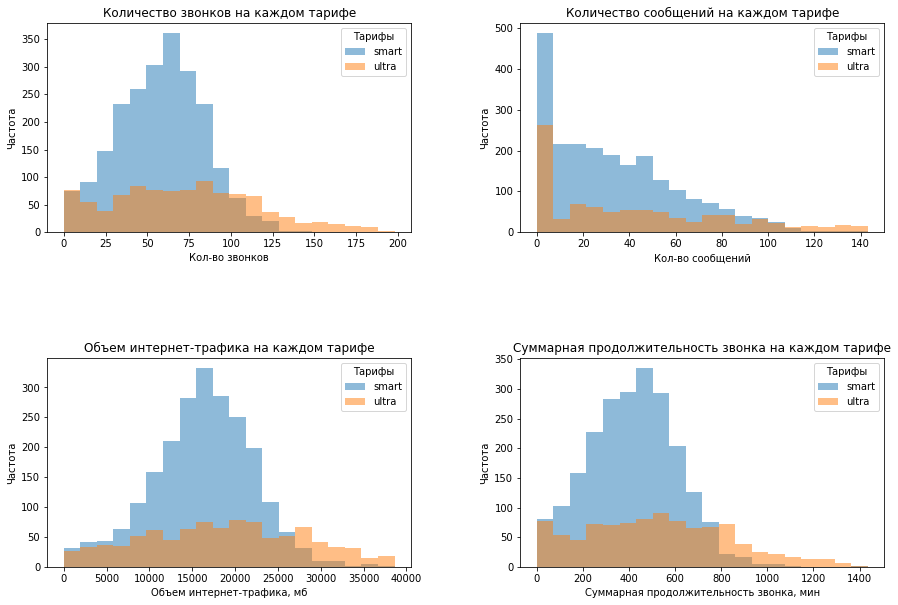

In [38]:
# построим гистограммы для кол-ва звонков, сообщений и интернета по каждому тарифу

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes[0,0].set_xlabel('Кол-во звонков')
axes[0,0].set_ylabel('Частота')
axes[0,0].set_title('Количество звонков на каждом тарифе')
_, bins, _ = axes[0,0].hist(tariff_smart['calls_count'], 
                            bins=20, 
                            alpha=0.5, 
                            label = 'smart')
axes[0,0].hist(tariff_ultra['calls_count'],
              bins=bins,
              alpha=0.5,
              label = 'ultra')
axes[0,0].legend(title="Тарифы")


axes[0,1].set_xlabel('Кол-во сообщений')
axes[0,1].set_ylabel('Частота')
axes[0,1].set_title('Количество сообщений на каждом тарифе')
_, bins, _ = axes[0,1].hist(tariff_smart['messages_count'], 
                            bins=20, 
                            alpha=0.5, 
                            label = 'smart')
axes[0,1].hist(tariff_ultra['messages_count'],
              bins=bins,
              alpha=0.5,
              label = 'ultra')
axes[0,1].legend(title="Тарифы")


axes[1,0].set_xlabel('Объем интернет-трафика, мб')
axes[1,0].set_ylabel('Частота')
axes[1,0].set_title('Объем интернет-трафика на каждом тарифе')
_, bins, _ = axes[1,0].hist(tariff_smart['mb_used_sum'], 
                            bins=20, 
                            alpha=0.5, 
                            label = 'smart')
axes[1,0].hist(tariff_ultra['mb_used_sum'],
              bins=bins,
              alpha=0.5,
              label = 'ultra')
axes[1,0].legend(title="Тарифы")

axes[1,1].set_xlabel('Суммарная продолжительность звонка, мин')
axes[1,1].set_ylabel('Частота')
axes[1,1].set_title('Суммарная продолжительность звонка на каждом тарифе')
_, bins, _ = axes[1,1].hist(tariff_smart['calls_duration'], 
                            bins=20, 
                            alpha=0.5, 
                            label = 'smart')
axes[1,1].hist(tariff_ultra['calls_duration'],
              bins=bins,
              alpha=0.5,
              label = 'ultra')
axes[1,1].legend(title="Тарифы")

plt.subplots_adjust(wspace=0.3, hspace=0.6) # задаем отступы
plt.show()

> *Кол-во звонков:*<br/>
Имеет нормальное распределение по обоим тарифам. У распределения тарифа "ультра" длинный правый хвост. 
Видим, что до 100 звонков в месяц гораздо больше у пользователей тарифа "смарт". Но более 100 звонков в месяц уже у пользователей тарифом "ультра". Более 150 звонков в месяц у пользователей тарифом "смарт" уже практически нет.


>*Кол-во сообщений:*<br/>
Распределение смещено влево.
Аналогично, до 100 сообщений в основном пишут на тарифе "смарт". А если сообщений написано более 100-115, то тут уже преобладает тариф "ультра". По гистограмме видно, что мало людей пишут много сообщений. Это и понятно, есть же соц.сети=)


>*Объем интернет-трафика:*<br/>
Имеет нормальное распределение по обоим тарифам.
До 25000мб используют в основном на тарифе "смарт",после 30000мб в основном используют на тарифе "ультра". На обоих тарифах используют одинаково мало трафика до 5000мб.


>*Суммарная продолжительность звонка:*<br/>
Имеет нормальное распределение с длинным правым хвостом. Это означает, что 800 мин в месяц и более разговаривают на тарифе "ультра". По тарифу "смарт" таких больших значений практически нет.

Проанализируем выручку по каждому тарифу. Построим гистограммы.

In [39]:
# рассчет средней месячной выручке для каждого тарифа
print('Средняя месячная выручка по тарифу')
print('----------------------------------')
df_with_tariffs.groupby('tariff_name')['receipts'].mean().round()

Средняя месячная выручка по тарифу
----------------------------------


tariff_name
smart    1233.0
ultra    2061.0
Name: receipts, dtype: float64

>Для данной выборке из 500 пользователей средняя ежемесячная выручка на тарифе "ультра" почти в два раза выше. Посмотрим на распределение выручки по каждому тарифу.

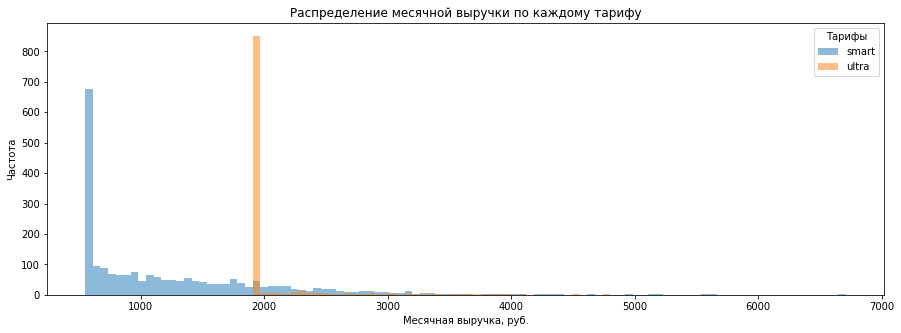

In [40]:
plt.figure(figsize =(15, 5))

_, bins, _ = plt.hist(tariff_smart['receipts'],
        bins=100,
        alpha=0.5,
        label='smart')
plt.xlabel('Месячная выручка, руб.')
plt.ylabel('Частота')

plt.hist(tariff_ultra['receipts'],
        bins=bins,
        alpha=0.5,
        label='ultra')
plt.xlabel('Месячная выручка, руб.')
plt.ylabel('Частота')

plt.title('Распределение месячной выручки по каждому тарифу')
plt.legend(title="Тарифы")
plt.show()

>Видим, что у тарифа "смарт" в основном выручка от 500 до 3000 руб в месяц, при этом у тарифа "ультра" выручка выше и начинается от 2000руб. Это и понятно, т.к. тариф ультра стоит 1950руб.

In [41]:
print('Максимальная месячная выручка на тарифе смарт:', tariff_smart['receipts'].max())
print('Максимальная месячная выручка на тарифе ультра:', tariff_ultra['receipts'].max())
       

Максимальная месячная выручка на тарифе смарт: 6711.02
Максимальная месячная выручка на тарифе ультра: 4743.31


>Интересно, что на тарифе "смарт" максимальная выручка больше. По гистограмме видно, что это единичные случаи.

<b><font size=3>Промежуточный вывод</font></b><br/>

По всем четырем параметрам: кол-во звонков, кол-во сообщений и объем интернет-трафика, суммарная продолжительность звонков в месяц среднее зачение выше примерно в 1,5 раза у тарифа "ультра". Тоже самое и со стандартным отклонение. Разброс значений у тарифа "ультра" также больше.

По гистограммам увидели, что на тарифе "ультра" больше пользователей, которые много звонят(от 100 звонков в месяц), пишут много сообщений (от 100-115), имеют продолжительность звонка от 800 минут и выше и больше пользуются интернетом. Но при этом, на тарифе "смарт" в общем больше пользователей.

По распределению выручки увидели, что у тарифа "смарт" в основном выручка от 500 до 3000 руб в месяц, при этом у тарифа "ультра" выручка выше и начинается от 2000руб. При этом на тарифе "смарт" максимальная выручка больше.

*Гипотеза:* тариф "ультра" приносит больше денег. Проверим эту гипотезу в сл.блоке.

<b><font size=5>4. Проверка гипотез</font></b><a name="4."></a>

<b><font size=4>4.1. Гипотеза о различии средней выручки для разных тарифов</font></b><a name="4.1."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Для начала проверим одинаковые ли дисперсии у выборок, применив тест Левена. <br/>
Гипотеза $H_0$: Дисперсии выручки для тарифа смарт и ультра равны.<br/>
Гипотеза $H_1$: Дисперсии выручки для тарифа смарт и ультра не равны.

Затем проверим равенство средних выручек у двух тарифов. <br/>
Сформулируем <b>нулевую гипотезу:</b> *средняя выручка пользователей тарифов «Ультра» и «Смарт» не отличается.* <br/>
<b>Альтернативная гипотеза:</b> *средняя выручка пользователей тарифов «Ультра» и «Смарт» отличается.*

И займем статистической проверкой гипотез.


In [42]:
# создадим series по выручке для каждого тарифа

receipts_smart = df_with_tariffs.loc[df_with_tariffs['tariff_name'] == 'smart', 'receipts']
receipts_ultra = df_with_tariffs.loc[df_with_tariffs['tariff_name'] == 'ultra', 'receipts']

In [43]:
def equal_means(a,b, alpha = 0.05):
    
    '''Функция сначала применяет тест Левена к двум выборка для проверки равенства дисперсий.
    Затем исходя из равенства/различия дисперсий применяет к этим выборкам t-test.
    '''
    
    results_levene = st.levene(a, b) # применяем тест Левена для проверки равенства дисперсий
    print('p-значение:', results_levene.pvalue)
    
    if results_levene.pvalue < alpha:
        print(colored("Отвергаем нулевую гипотезу (о дисперсии)", 'red'))
        equal_var = False # дисперсии выборок не равны
    else: 
        print(colored("Не можем отвергнуть нулевую гипотезу (о дисперсии)", 'green'))
        equal_var = True # дисперсии выборок равны
        
    # проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
    results = st.ttest_ind(a, b, equal_var=equal_var) 
    print('p-значение:', results.pvalue)
    
    if results.pvalue < alpha:
        print(colored("Отвергаем нулевую гипотезу", 'red'))
    else: 
        print(colored("Не можем отвергнуть нулевую гипотезу", 'green'))

In [44]:
# применяем написанную функцию к выборкам по двум тарифам

equal_means(receipts_smart, receipts_ultra, alpha = 0.05)

p-значение: 3.135578626683539e-115
Отвергаем нулевую гипотезу (о дисперсии)
p-значение: 8.930336877790439e-296
Отвергаем нулевую гипотезу


>Согласно тесту Левена дисперсии выборок разные. Это учитываем при проведении t-теста.<br/>
По t-тесту нулевую гипотезу о равенстве средних выручек по двум тарифам отвергаем. Значит средняя выручка по каждому тарифу существенно отличается.

<b><font size=3>Промежуточный вывод</font></b><br/>

Для сравнения выручки по каждому тарифу воспользовались тестом st.ttest_ind, который проверяет гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Согласно тесту средняя выручка по каждому тарифу отличается.
Ранее считали и увидели, что средняя ежемесячная выручка на тарифе "ультра" почти в два раза выше по данным из конкретной выборки.

Гипотеза в выводе п.3 не отвергнута.

<b><font size=4>4.2. Гипотеза о различии средней выручки для пользователей из Москвы и из других регионов</font></b><a name="4.2."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)


In [45]:
receipts_moscow = df_with_tariffs.loc[df_with_tariffs['city'] == 'Москва', 'receipts'] # пользователи из Москвы

receipts_region = df_with_tariffs.loc[df_with_tariffs['city'] != 'Москва', 'receipts'] # пользователи из регионов

In [46]:
print('Средняя месячная выручка для пользователей из Москвы', round(receipts_moscow.mean()))

print('Средняя месячная выручка для пользователей из регионов', round(receipts_region.mean()))

Средняя месячная выручка для пользователей из Москвы 1507
Средняя месячная выручка для пользователей из регионов 1482


>Если просто посчитать среднее значение выручки, то они не так уж и различны для Москвы и регионов. Посмотрим что скажет тест.

<b>Нулевая гипотеза:</b> средняя выручка у пользователей из Москвы и из регионов не отличается.<br/>
<b>Альтернативная гипотеза:</b> средняя выручка у пользователей из Москвы и из регионов отличается.<br/>

In [47]:
# считаем два теста: Левена и t-тест

equal_means(receipts_moscow, receipts_region, alpha = 0.05)

p-значение: 0.021465924014568014
Отвергаем нулевую гипотезу (о дисперсии)
p-значение: 0.4549784322403716
Не можем отвергнуть нулевую гипотезу


>Нулевую гипотезу не получилось отвергнуть. Полученное значение p-value говорит о том, что хотя средняя выручка и отличается для жителей из Москвы и из регинов, с вероятностью в 45% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

<b><font size=3>Промежуточный вывод</font></b><br/>

Для сравнения выручки по каждому тарифу воспользовались тестом st.ttest_ind, который проверяет гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Согласно тесту средняя выручка для Москвы и регионов не отличается. В 45% случаев различие можно получить случайно.

<b><font size=5>5. Общий вывод</font></b><a name="5."></a><br/>
[<font size="2">(к содержанию)</font>](#1common.)

<b>Изучив данные 500 пользователей компании были сделаны сл.выводы:</b>

* Из 500 пользователей в выборке 70% - это пользователи тарифом "смарт", 30% - тарифом "ультра". Все пользователи подключились в 2018г. Из них на момент выгрузки данных 92% являются абонентами компании, 8% - отключили услуги компании.

* В среднем на тарифе "ультра" пользователи тратят в 1.3 раза больше минут для разговора, сообщений и трафика.

* На тарифе "ультра" больше пользователей, которые много звонят(от 100 звонков в месяц), пишут много сообщений (от 100-115), разговаривают от 800 минут в месяц и больше пользуются интернетом. Но при этом, на тарифе "смарт" в общем больше пользователей с меньшим кол-вом звонков, сообщений и интернета.

<b>Было проверено две гипотезы:</b>

1) Средняя выручка пользователей тарифов «Ультра» и «Смарт» не отличается. Эта гипотеза была отвергнута по результатам t-теста. Средняя выручка на тарифах существенно различается. Посчитав среднюю выручку по каждому тарифу по данным 500 пользователей увидели, что у тарифа "ультра" выручка почти в 2 раза выше.

2) Средняя выручка у пользователей из Москвы и из регионов не отличается. Гипотеза не отвергнута. Согласно тесту средняя выручка для Москвы и регионов не отличается. В 33% случаев различие можно получить случайно.

<b>Была продела сл.работа с данными:</b>

* Во многих столбцах изменены типы данных на соответствующие данным в столбце и для того, чтобы снизить потребление памяти.
* Добавлены новые данные в разбивке по месяцам: кол-во звонков, сообщений, объем интернет-трафика, выручка по каждому пользователю.

<b>Рекоменации:</b>

В результате анализа двух тарифов было выяснено, что тариф "ультра" приносит больше денег компании. В связи с этим рекомендуется скорректировать рекламный бюджет в пользу тарифа "ультра" в 2019г.